# Build a Reflective Self-Correcting Code Generation AI Agent

In this project we will be building an intelligent self-correction code generation AI Agent which can generate working code for user problems, leverage the reflection pattern to examine and test the code and improve and correct it.

![](https://i.imgur.com/koLDCZL.png)

### Reflective Self-Correcting Code Generation AI Agent

This project focuses on building a **Reflective Self-Correcting Code Generation AI Agent**, designed to iteratively generate, execute, and refine code to achieve accurate solutions. The workflow integrates reflective reasoning and error analysis to ensure robust and functional code generation. The workflow includes the following components:

1. **Code Generation**:
   - The system utilizes **OpenAI GPT-4o** to generate code based on the user's input and problem requirements.
   - Code is generated following a predefined schema, including:
     - **Prefix**: Problem description or setup requirements.
     - **Imports**: Necessary libraries or dependencies.
     - **Code**: Functional implementation of the solution.

2. **Code Execution and Reflection**:
   - The generated code is executed, and the results are analyzed.
   - If an error occurs, feedback is provided to refine the code:
     - **Error Feedback**: Captures errors or unexpected behaviors during execution.
     - **Reflection**: GPT-4o reflects on the error feedback to iteratively improve the solution.

3. **Iterative Correction Loop**:
   - The system repeats the generate-execute-reflect cycle until:
     - A successful solution is achieved (no errors).
     - The attempt count exceeds a predefined threshold (`N`), ensuring the loop terminates if a solution cannot be reached.

4. **Attempt Counter**:
   - Tracks the number of attempts (`K`) and increments with each iteration.
   - If the attempt count exceeds the predefined threshold, the process halts, and the user is informed.

5. **Final Validation**:
   - Once the code passes execution without errors, the refined solution is presented to the user as the final output.

6. **User Feedback Loop**:
   - If the user is unsatisfied with the solution, the process can be restarted to refine the code further or adjust the requirements.




## Install OpenAI, LangGraph and LangChain dependencies

In [1]:
# !pip install langchain==0.3.14
# !pip install langchain-openai==0.3.0
# !pip install langchain-community==0.3.14
# !pip install langgraph==0.2.64

In [3]:
from langchain_openai import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate
from pydantic import BaseModel, Field


## Enter LLM Details

In [4]:
def get_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",          
        temperature=0,
        api_key="EMPTY",              
        base_url="http://localhost:5005/v1",
    )

llm = get_llm()

## Build Code Generator

In [6]:
from langchain_openai import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate
from pydantic import BaseModel, Field


# Prompt
CODE_GEN_SYS_PROMPT = [
        (
            "system",
            """You are a coding assistant.
                Ensure any code you provide can be executed with all required imports and variables defined.
                Make sure point 3 below has some code to run and execute any code or functions which you define

                Structure your answer as follows:
                  1) a prefix describing the code solution
                  2) the imports (if no imports needed keep it empty string)
                  3) the functioning code blocks

                Here is the user question:""",
        )
]

# Data model
class Code(BaseModel):
    """Schema for code solutions to questions about coding."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Just the import statements of the code")
    code: str = Field(description="Code blocks not including import statements")

# LLM
code_generator = llm.with_structured_output(Code)

In [7]:
question = "How to create fibonacci series"
messages = [("user", question)]

result = code_generator.invoke(CODE_GEN_SYS_PROMPT + messages)
result

Code(prefix='Here is a simple, self‑contained Python implementation that generates the Fibonacci series. It includes a function to return the first *n* terms, a generator version for lazy evaluation, and a small demo that prints the first 10 numbers.', imports='# No external imports are required\n', code='# Function that returns the first n Fibonacci numbers as a list\n\ndef fibonacci_list(n: int) -> list[int]:\n    """Return a list containing the first *n* Fibonacci numbers.\n\n    Parameters\n    ----------\n    n : int\n        The number of terms to generate. Must be non‑negative.\n\n    Returns\n    -------\n    list[int]\n        A list of the first *n* Fibonacci numbers.\n    """\n    if n < 0:\n        raise ValueError("n must be non‑negative")\n    if n == 0:\n        return []\n    if n == 1:\n        return [0]\n\n    fib_seq = [0, 1]\n    while len(fib_seq) < n:\n        fib_seq.append(fib_seq[-1] + fib_seq[-2])\n    return fib_seq\n\n# Generator that yields Fibonacci numbe

In [8]:
print(result.code)

# Function that returns the first n Fibonacci numbers as a list

def fibonacci_list(n: int) -> list[int]:
    """Return a list containing the first *n* Fibonacci numbers.

    Parameters
    ----------
    n : int
        The number of terms to generate. Must be non‑negative.

    Returns
    -------
    list[int]
        A list of the first *n* Fibonacci numbers.
    """
    if n < 0:
        raise ValueError("n must be non‑negative")
    if n == 0:
        return []
    if n == 1:
        return [0]

    fib_seq = [0, 1]
    while len(fib_seq) < n:
        fib_seq.append(fib_seq[-1] + fib_seq[-2])
    return fib_seq

# Generator that yields Fibonacci numbers indefinitely

def fibonacci_generator():
    """Yield Fibonacci numbers one by one.

    This generator can be used in a loop or with ``itertools.islice`` to
    obtain a finite number of terms.
    """
    a, b = 0, 1
    while True:
        yield a
        a, b = b, a + b

# Demo: print the first 10 Fibonacci numbers
if __name_

In [9]:
print(result.imports)

# No external imports are required



We create a chain that returns structured data for code solutions. We’ll feed it the user’s question plus the system directive in the prompt above.

## Build Agent Graph Node Functions

The key focus here will be to create the function implementations of the main nodes in our graph which will include:

-  **Generate** a code solution
-  **Check code** imports and code execution and add error messages if any
- **Conditional routing** to regenerate code by reflecting on the errors if any OR stop generation



### Create Agent State Schema

In [10]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import HumanMessage

class CodeGenState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error_flag : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        code_solution : Code solution
        attempts : Number of tries
    """
    error_flag: str
    messages: Annotated[List[AnyMessage], add_messages]
    code_solution: str
    attempts: int

### Node 1: Generate Code

In [11]:

def generate_code(state: CodeGenState) -> CodeGenState:
    """Generate code solution from LLM, structured as prefix/imports/code."""
    print("--- GENERATING CODE SOLUTION ---")
    msgs = state["messages"]
    attempts_so_far = state["attempts"]

    # Call code_generation_chain
    code_soln = code_generator.invoke(CODE_GEN_SYS_PROMPT + msgs)

    # We'll record the chain's answer as a new assistant message in conversation.
    new_msg_content = (f"Here is my solution attempt:\n\nDescription: {code_soln.prefix}\n\n"
                       f"Imports: {code_soln.imports}\n\n"
                       f"Code:\n{code_soln.code}")

    msgs.append(("assistant", new_msg_content))
    attempts_so_far += 1

    return {
        "messages": msgs,
        "code_solution": code_soln,
        "attempts": attempts_so_far
    }

### Node 2: Check Code

We try to `exec` the imports, then `exec` the code. If errors occur, we pass them back to the conversation. Otherwise, success.

In [12]:
# sample code of how exec works
user_code = """
x = 5
y = 15
print('Result:', x * y)
"""
exec(user_code)

Result: 75


In [13]:
def check_code_execution(state: CodeGenState) -> CodeGenState:
    print("--- CHECKING CODE EXECUTION ---")
    msgs = state["messages"]
    code_soln = state["code_solution"]
    imports_str = code_soln.imports
    code_str = code_soln.code
    attempts = state["attempts"]

    # Attempt to import:
    try:
        exec(imports_str)
    except Exception as e:
        # Import failed
        print("---CODE IMPORT CHECK: FAILED---")
        error_msg = f"""Import test failed!
                        Here is the exception trace details:
                        {e}.

                        Please fix the import section."""

        msgs.append(("user", error_msg))
        return {
            "code_solution": code_soln,
            "attempts": attempts,
            "messages": msgs,
            "error_flag": "yes"
        }

    # Attempt to run code:
    try:
        scope = {}
        exec(f"{imports_str}\n{code_str}", scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_msg =  f"""Your code solution failed the code execution test!
                            Here is the exception trace details:
                            {e}

                            Reflect on this error and your prior attempt to solve the problem.

                            (1) State what you think went wrong with the prior solution
                            (2) try to solve this problem again.

                            Return the FULL SOLUTION.

                            Use the code tool to structure the output with a prefix, imports, and code block."""

        msgs.append(("user", error_msg))
        return {
            "code_solution": code_soln,
            "attempts": attempts,
            "messages": msgs,
            "error_flag": "yes"
        }

    # If no errors:
    print("--- NO ERRORS FOUND ---")
    return {
            "code_solution": code_soln,
            "attempts": attempts,
            "messages": msgs,
            "error_flag": "no"
    }

### Conditional Routing to Decide Next Step

In [14]:
MAX_ATTEMPTS = 3

def decide_next(state: CodeGenState) -> str:
    """If error or attempts < MAX_ATTEMPTS => go generate. Else end."""
    err = state["error_flag"]
    attempts = state["attempts"]
    if err == "no" or attempts >= MAX_ATTEMPTS:
        print("--- DECISION: FINISH ---")
        return "__end__"
    else:
        print("--- DECISION: RETRY ---")
        return "generate_code"

## Build the Reflection Agentic Graph

We'll define the nodes and edges in LangGraph, then run it.

In [15]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage

graph = StateGraph(CodeGenState)

# Add nodes:
graph.add_node("generate_code", generate_code)
graph.add_node("check_code", check_code_execution)

# Edges:
graph.set_entry_point("generate_code")
graph.add_edge("generate_code", "check_code")
graph.add_conditional_edges(
    "check_code",
    decide_next,
    [END, "generate_code"]
)

coder_agent = graph.compile()


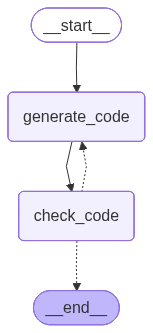

In [16]:
from IPython.display import display, Image, Markdown

display(Image(coder_agent.get_graph().draw_mermaid_png()))

## Run and Test the Agent

In [17]:
from langchain_core.messages import HumanMessage

def call_reflection_coding_agent(agent, prompt, verbose=False):
    events = agent.stream(
        {"messages": [HumanMessage(content=prompt)], "attempts": 0},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
            event["messages"][-1].pretty_print()

    print('\n\nFinal Solution:')
    print("\nDescription:\n" + event["code_solution"].prefix +
          "\nCode:\n"+event["code_solution"].imports + '\n\n' + event["code_solution"].code)

In [18]:
prompt = "write some code to demonstrate how to do a pivot table in pandas"
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

write some code to demonstrate how to do a pivot table in pandas
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: Below is a minimal, self‑contained example that shows how to create a pivot table in pandas. It builds a small DataFrame, uses `pivot_table` to aggregate data, and prints the result. You can copy‑paste the entire snippet into a Python environment and run it directly.

Imports: import pandas as pd
import numpy as np

Code:
# Create a sample DataFrame
np.random.seed(0)

df = pd.DataFrame({
    'Store': ['A', 'A', 'B', 'B', 'C', 'C', 'C'],
    'Product': ['Apple', 'Banana', 'Apple', 'Banana', 'Apple', 'Banana', 'Cherry'],
    'Sales': [120, 80, 150, 90, 200, 110, 70],
    'Quantity': [10, 5, 12, 6, 20, 11, 7]
})

print("Original DataFrame:\n", df)

# Pivot tab

In [19]:
prompt = "write some code how to extract code from .ipynb notebook and make it .py without any error."
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

write some code how to extract code from .ipynb notebook and make it .py without any error.
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: This script reads a Jupyter Notebook (.ipynb) file, extracts all code cells, and writes them to a plain Python (.py) file. It uses the `nbformat` library (part of the Jupyter ecosystem) to parse the notebook JSON structure safely. The code includes basic error handling and a small demo that can be run directly from the command line.

**Prerequisites**: `pip install nbformat` if you don’t already have it.

**Usage**:
```bash
python extract_notebook.py path/to/notebook.ipynb path/to/output.py
```

If you run the script without arguments it will print a short help message.

---

**Imports**


Imports: import sys
import os
import nbfo

In [18]:
prompt = """Give me working code to get data from Twitter using API"""
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

Give me working code to get data from Twitter using API
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To access data from Twitter using their API, you need to use the Tweepy library, which is a popular Python library for accessing the Twitter API. First, you need to create a Twitter Developer account and create an app to get your API keys and tokens. Once you have these credentials, you can use Tweepy to authenticate and fetch data from Twitter.

Imports: import tweepy

Code:
# Replace these with your own credentials
API_KEY = 'your_api_key'
API_SECRET_KEY = 'your_api_secret_key'
ACCESS_TOKEN = 'your_access_token'
ACCESS_TOKEN_SECRET = 'your_access_token_secret'

# Authenticate to Twitter
auth = tweepy.OAuth1UserHandler(API_KEY, API_SECRET_KEY, ACCESS_TOKEN, ACCESS_

In [19]:
prompt = """Give me working code to do sentiment analysis using transformers"""
call_reflection_coding_agent(coder_agent, prompt, verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

Give me working code to do sentiment analysis using transformers
--- GENERATING CODE SOLUTION ---
================================== Ai Message ==================================

Here is my solution attempt:

Description: To perform sentiment analysis using transformers, we can use the Hugging Face Transformers library. This library provides pre-trained models that can be easily used for various NLP tasks, including sentiment analysis. We'll use the `pipeline` function from the Transformers library to load a pre-trained sentiment analysis model and analyze the sentiment of a given text.

Imports: from transformers import pipeline

Code:
# Load the sentiment-analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Example text for sentiment analysis
text = "I love using transformers for NLP tasks!"

# Perform sentiment analysis
result = sentiment_pipeline(text